In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from pathlib import Path

import sys
from plotly_resampler import FigureResampler
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sys.path.append("..")
from sgs_utils.path_conf import loc_data_dir, interim_speech_data_dir
from sgs_utils.data_filtering import get_valid_audio_mask
from sgs_utils.dataframes import groupby_consecutive
from sgs_utils.processing import sqi_smoothen
import noisereduce as nr

In [5]:
# Load in the session data
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_tot_cleaned.parquet"))
# df_lld_gemaps = pd.read_parquet(loc_data_dir.joinpath('df_gemaps_lld_full_dur.parquet'))
df_lld_compare = pd.read_parquet(loc_data_dir.joinpath('df_compare_lld_full_dur.parquet'))
df_vad = pd.read_parquet(loc_data_dir.joinpath('df_vad.parquet'))
df_vad_nr = pd.read_parquet(loc_data_dir.joinpath('df_vad_nr.parquet')) # VAD output calculated on sationnairy reduced noise data

df_session_v = df_session[
    get_valid_audio_mask(df_session) & (df_session.wav_duration_s > 16.5)
]

FileNotFoundError: [Errno 2] No such file or directory: '/home/jonas/git/github/semi-guided-speech/loc_data/df_compare_lld_full_dur.parquet'

In [36]:
# session_of_interest = df_session[df_session.ID == '28d01050-e4e0-4115-a5e9-09c8cb917fb0'].sample(1).iloc[0]
session_of_interest = df_session_v.sample(1).iloc[0]

npy_file = list(interim_speech_data_dir.glob(f'full_dur_16khz_norm/{session_of_interest.ID}/*/*{session_of_interest.time_str}.npy'))[0]
"  -  ".join([npy_file.parent.parent.name.split('__')[-1], npy_file.parent.name, npy_file.stem])

'0ce7b123-c80b-44f3-ad3e-f935d9072cef  -  PiSCES  -  Picture 82__14:31:09'

In [37]:
# get the LLD's
# df_lld_gemaps_utt = df_lld_gemaps[(df_lld_gemaps.ID == session_of_interest.ID) & (df_lld_gemaps.time_str == session_of_interest.time_str)].reset_index().copy()
# df_lld_gemaps_utt["t_end_s"] = pd.to_timedelta(df_lld_gemaps_utt['end'].astype(str)).dt.total_seconds().astype(np.float32)
# display(df_lld_gemaps_utt[["t_end_s", "F0semitoneFrom27.5Hz_sma3nz"]].head(3))

df_lld_compare_utt = df_lld_compare[(df_lld_compare.ID == session_of_interest.ID) & (df_lld_compare.time_str == session_of_interest.time_str)].reset_index().copy()
df_lld_compare_utt["t_end_s"] = pd.to_timedelta(df_lld_compare_utt['end'].astype(str)).dt.total_seconds().astype(np.float32)
df_lld_compare_utt["t_start_s"] = pd.to_timedelta(df_lld_compare_utt['start'].astype(str)).dt.total_seconds().astype(np.float32)
df_lld_compare_utt['time_s'] = (df_lld_compare_utt.t_start_s + df_lld_compare_utt.t_end_s) / 2
# display(df_lld_compare_utt[["t_start_s", "t_end_s", "F0final_sma"]].head(3))

# get the VAD
df_vad_utt = df_vad[(df_vad.ID == session_of_interest.ID) & (df_vad.time_str == session_of_interest.time_str)].reset_index().copy()
df_vad_utt_nr = df_vad_nr[(df_vad_nr.ID == session_of_interest.ID) & (df_vad_nr.time_str == session_of_interest.time_str)].reset_index().copy()

# Fetch the raw data
x, sr = np.load(npy_file).ravel(), 16_000

reduced_noise = nr.reduce_noise(y=x, sr=sr, stationary=True)

In [17]:
# from IPython.display import Audio

# Audio(x, rate=16_000, autoplay=False)

In [19]:
# from IPython.display import Audio

# Audio(reduced_noise, rate=16_000, autoplay=False)

In [14]:
# fig = FigureResampler(make_subplots(rows=4, cols=1, shared_xaxes=True, specs=[[{'secondary_y': True}], [{}], [{}], [{}]]))

# fig.add_trace(
#     go.Scattergl(),
#     hf_x=np.arange(0, step=1 / sr, stop=len(x) / sr)[: len(x)],
#     hf_y=x,
# )


# fig.add_trace(
#     go.Scattergl(name='reduced_noise'),
#     hf_x=np.arange(0, step=1 / sr, stop=len(x) / sr)[: len(x)],
#     hf_y=reduced_noise,
#     row=2,
#     col=1,
# )


# fig.add_trace(
#     go.Scatter(
#         x=df_lld_compare_utt.time_s,
#         y=df_lld_compare_utt["F0final_sma"],
#         name="F0Final-start",
#     ),
#     row=3,
#     col=1,
# )


# fig.add_trace(
#     go.Scatter(
#         x=df_lld_compare_utt.time_s,
#         y=df_lld_compare_utt["logHNR_sma"],
#         name="log-hnr",
#     ),
#     row=3,
#     col=1,
# )


# fig.add_trace(go.Scattergl(x=df_vad_utt.time_s, y=df_vad_utt.voice_proba, name="VAD-pyannote"), row=4, col=1)
# fig.add_trace(go.Scattergl(x=df_vad_utt_nr.time_s, y=df_vad_utt_nr.voice_proba, name="VAD-pyannote NR"), row=4, col=1)


# voiced = (((df_lld_compare_utt.F0final_sma > 80) & (df_lld_compare_utt.F0final_sma < 250) &  (df_lld_compare_utt.logHNR_sma > 0)) | (df_lld_compare_utt.logHNR_sma > 5)).rename("voiced")
# fig.add_trace(go.Scattergl(x=df_lld_compare_utt.time_s, y=voiced, name="voiced-RAW", line_shape='hvh', visible='legendonly'), secondary_y=True)


# gc = groupby_consecutive(voiced)
# gc['delta'] = (gc['end'] - gc['start']) * 0.01

# for _, r in gc[(gc['delta'] < 0.3) & (gc.voiced == False)].iterrows():
#     voiced[r.start - 1:int(r.next_start)] = True
# voiced_sm = sqi_smoothen(voiced, fs=60, window_s=0.3, min_ok_ratio=0.5, operation='and')

# fig.add_trace(
#     go.Scattergl(x=df_lld_compare_utt.time_s, y=voiced, name="VAD-GC", line_shape='hvh'),
#     secondary_y=True,
# )
# fig.add_trace(
#     go.Scattergl(x=df_lld_compare_utt.time_s, y=voiced_sm, name="VAD-GC-sm", line_shape='hvh'),
#     secondary_y=True,
# )


# fig.update_layout(height=800, template='plotly_white', title="  -  ".join([npy_file.parent.parent.name.split('__')[-1], npy_file.parent.name, npy_file.stem]), title_x=0.5)
# fig.update_yaxes(categoryarray=['false', 'true'])
# fig.show_dash(mode="external", port=9025)

# fig.show(renderer="png", width=1300)


Dash app running on http://127.0.0.1:9028/


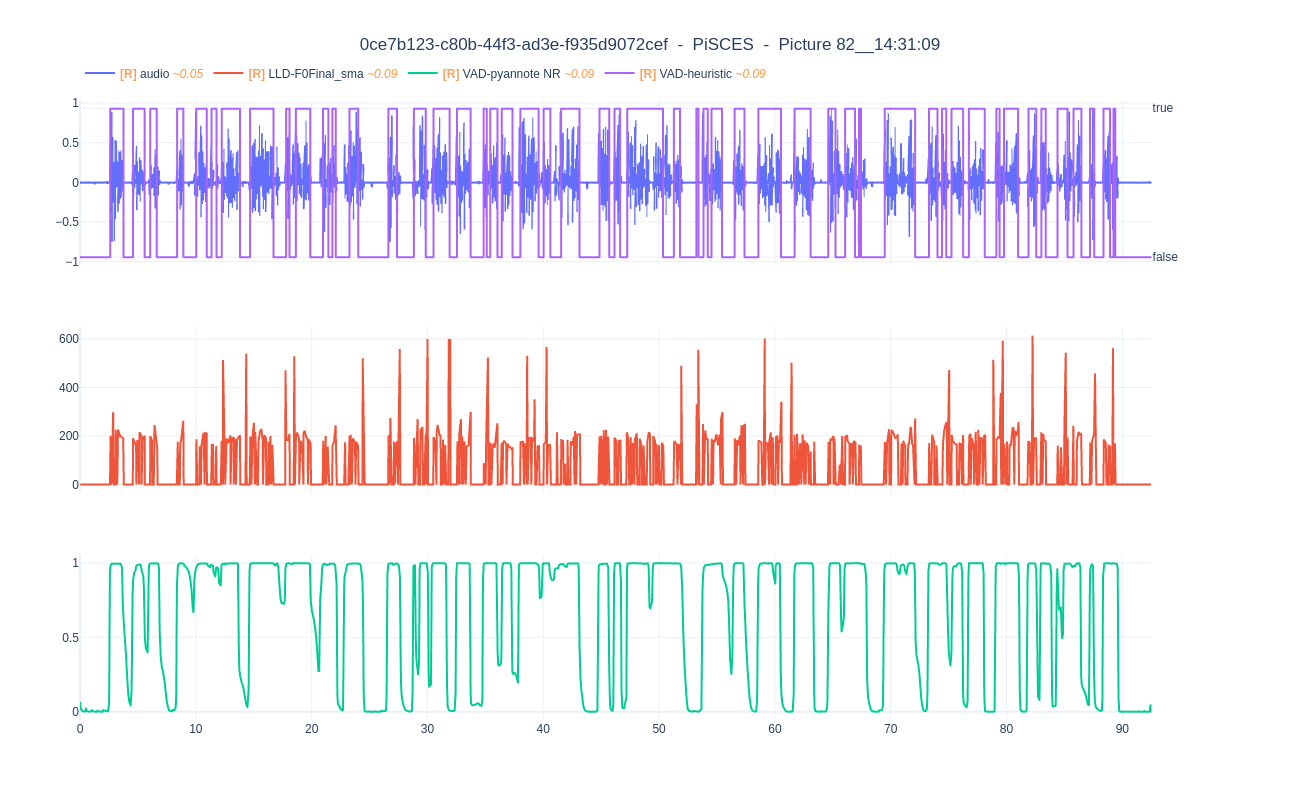

In [38]:
fig = FigureResampler(make_subplots(rows=3, cols=1, shared_xaxes=True, specs=[[{'secondary_y': True}], [{'secondary_y': True}], [{}]]))

fig.add_trace(
    go.Scattergl(name='audio'),
    hf_x=np.arange(0, step=1 / sr, stop=len(x) / sr)[: len(x)],
    hf_y=x,
    max_n_samples=2000
)


# fig.add_trace(
#     go.Scattergl(name='reduced_noise'),
#     hf_x=np.arange(0, step=1 / sr, stop=len(x) / sr)[: len(x)],
#     hf_y=reduced_noise,
#     row=2,
#     col=1,
# )


fig.add_trace(
    go.Scatter(
        x=df_lld_compare_utt.time_s,
        y=df_lld_compare_utt["F0final_sma"],
        name="LLD-F0Final_sma",
    ),
    row=2,
    col=1,
)


# fig.add_trace(
#     go.Scatter(
#         x=df_lld_compare_utt.time_s,
#         y=df_lld_compare_utt["logHNR_sma"],
#         name="LLD-logHNR_sma",
#     ),
#     secondary_y=True,
#     row=2,
#     col=1,
# )


# fig.add_trace(go.Scattergl(x=df_vad_utt.time_s, y=df_vad_utt.voice_proba, name="VAD-pyannote no NR"), row=3, col=1)
fig.add_trace(go.Scattergl(x=df_vad_utt_nr.time_s, y=df_vad_utt_nr.voice_proba, name="VAD-pyannote NR"), row=3, col=1)


voiced = (((df_lld_compare_utt.F0final_sma > 80) & (df_lld_compare_utt.F0final_sma < 250) &  (df_lld_compare_utt.logHNR_sma > 0)) | (df_lld_compare_utt.logHNR_sma > 5)).rename("voiced")
# fig.add_trace(go.Scattergl(x=df_lld_compare_utt.time_s, y=voiced, name="voiced-RAW", line_shape='hvh', visible='legendonly'), secondary_y=True)


gc = groupby_consecutive(voiced)
gc['delta'] = (gc['end'] - gc['start']) * 0.01

for _, r in gc[(gc['delta'] < 0.3) & (gc.voiced == False)].iterrows():
    voiced[r.start - 1:int(r.next_start)] = True
voiced_sm = sqi_smoothen(voiced, fs=60, window_s=0.3, min_ok_ratio=0.5, operation='and')

# fig.add_trace("""  """
#     go.Scattergl(x=df_lld_compare_utt.time_s, y=voiced, name="VAD-GC", line_shape='hvh'),
#     secondary_y=True,
# )
fig.add_trace(
    go.Scattergl(x=df_lld_compare_utt.time_s, y=voiced_sm, name="VAD-heuristic", line_shape='hvh'),
    secondary_y=True,
)


fig.update_layout(height=800, template='plotly_white', title="  -  ".join([npy_file.parent.parent.name.split('__')[-1], npy_file.parent.name, npy_file.stem]), title_x=0.5)
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0))

fig.update_yaxes(categoryarray=['false', 'true'])
fig.show_dash(mode="external", port=9028)

fig.show(renderer="png", width=1300)


In [70]:
# fig = FigureResampler(make_subplots(rows=3, cols=1, shared_xaxes=True, specs=[[{'secondary_y': True}], [{}], [{}]]))

# fig.add_trace(
#     go.Scattergl(),
#     hf_x=np.arange(0, step=1 / sr, stop=len(x) / sr)[: len(x)],
#     hf_y=x,
# )


# fig.add_trace(
#     go.Scatter(
#         x=df_lld_compare_utt["t_start_s"],
#         y=df_lld_compare_utt["F0final_sma"],
#         name="F0Final-start",
#     ),
#     row=2,
#     col=1,
# )


# fig.add_trace(
#     go.Scatter(
#         x=df_lld_compare_utt["t_end_s"],
#         y=df_lld_compare_utt["F0final_sma"],
#         name="F0Final-start",
#     ),
#     row=2,
#     col=1,
# )


# fig.add_trace(go.Scattergl(x=df_vad_utt.time_s, y=df_vad_utt.voice_proba, name="VAD-pyannote"), row=3, col=1)

# df_vad_comp = pd.merge_asof(df_lld_compare_utt[['t_end_s', 't_start_s', 'F0final_sma']], df_vad_utt, right_on='time_s', left_on='t_start_s', direction='forward', tolerance=0.015).dropna(how='any', axis=0).reset_index(drop=True)
# voiced = ((df_vad_comp.voice_proba > 0.995) | (df_vad_comp.F0final_sma > 80) & (df_vad_comp.F0final_sma < 450)).rename("SQI_smoothend")

# fig.add_trace(
#     go.Scattergl(x=df_vad_comp.t_start_s, y=voiced, name="VAD-threshold", line_shape='hvh', visible='legendonly'
# ),
#     row=1,
#     col=1,
#     secondary_y=True,    
# )


# voiced_sm = voiced
# # sqi_smoothen(voiced, fs=60, window_s=0.4, min_ok_ratio=0.5, operation='or')

# gc = groupby_consecutive(voiced_sm)
# gc['delta'] = (gc['end'] - gc['start']) * 0.01
# voiced_sm_cp = voiced_sm.copy()
# for _, r in gc[(gc['delta'] < 0.3) & (gc.SQI_smoothend == False)].iterrows():
#     voiced_sm_cp[r.start - 1:int(r.next_start)] = True

# # voiced_sm = sqi_smoothen(voiced_sm, fs=60, window_s=0.4, min_ok_ratio=0.5, operation='or')
# # voiced_sm = sqi_smoothen(voiced_sm, fs=60, window_s=0.8, min_ok_ratio=0.5, operation='or')
# # voiced_sm = sqi_smoothen(voiced_sm, fs=60, window_s=0.8, min_ok_ratio=0.5, operation='or')
# # voiced_sm = sqi_smoothen(voiced_sm, fs=60, window_s=2, min_ok_ratio=0.5, operation='or')

# voiced_sm_cp = sqi_smoothen(voiced_sm_cp, fs=60, window_s=1, min_ok_ratio=0.5, operation='and')
# # voiced_sm = sqi_smoothen(voiced_sm, fs=60, window_s=2, min_ok_ratio=0.5, operation='and')
# # voiced_sm = sqi_smoothen(~voiced_sm, fs=60, window_s=2, min_ok_ratio=0.5, flip=True)
# # voiced_sm = sqi_smoothen(~voiced_sm, fs=60, window_s=1, min_ok_ratio=0.5, flip=True)
# # voiced_sm_left = sqi_smoothen(~voiced_sm, fs=60, window_s=0.8, min_ok_ratio=0.4, flip=True, window_pos='left')
# # voiced_sm_right = sqi_smoothen(~voiced_sm, fs=60, window_s=0.4, min_ok_ratio=0.5, flip=True, window_pos='right')
# # voiced_sm = ~sqi_smoothen(~voiced_sm, fs=60, window_s=0.4, min_ok_ratio=0.5)
# # voiced_sm = sqi_smoothen(voiced_sm, fs=60, window_s=0.2, min_ok_ratio=0.7)
# # # voiced_sm = sqi_smoothen(voiced_sm, fs=60, window_s=1, min_ok_ratio=0.5)

# fig.add_trace(
#     go.Scattergl(x=df_vad_comp.t_start_s, y=voiced_sm, name="VAD-smoothened", line_shape='hvh'),
#     secondary_y=True,
# )
# fig.add_trace(
#     go.Scattergl(x=df_vad_comp.t_start_s, y=voiced_sm_cp, name="VAD-GC", line_shape='hvh'),
#     secondary_y=True,
# )

# fig.update_layout(height=800, template='plotly_white', title="  -  ".join([npy_file.parent.parent.name.split('__')[-1], npy_file.parent.name, npy_file.stem]), title_x=0.5)
# fig.update_yaxes(categoryarray=['false', 'true'])
# fig.show_dash(mode="external")

# fig.show(renderer="png", width=1300)


In [9]:
# for _, session_of_interest in df_session_v.sample(10).iterrows():
#     wav = list(
#         speech_data_root_dir.glob(
#             f"backup/*{session_of_interest.ID}*/{session_of_interest.DB}/*{session_of_interest.time_str}*.wav"
#         )
#     )[0]
#     wav

#     # process the LLD's
#     df_feat_lld_compare = lld_compare.process_file(wav)
#     df_feat_lld_compare = df_feat_lld_compare.reset_index()
#     df_feat_lld_compare["t_end_s"] = df_feat_lld_compare["end"].dt.total_seconds()

#     # apply the pyanote VAD pipeline on the wav file
#     out = pipeline._segmentation(wav)
#     probas = out.data.ravel()
#     sliding_window = out.sliding_window
#     time = np.arange(
#         start=sliding_window.start + sliding_window.duration,
#         step=sliding_window.step,
#         stop=sliding_window.start + sliding_window.duration + sliding_window.step * probas.shape[0],
#         dtype='float64'
#     )

#     # Fetch the raw data
#     x, sr = librosa.load(wav.as_posix(), sr=16_000)

#     # Create the visualization
#     fig = FigureResampler(make_subplots(rows=3, cols=1, shared_xaxes=True, specs=[[{'secondary_y': True}], [{}], [{}]]))

#     fig.add_trace(
#         go.Scattergl(),
#         hf_x=np.arange(0, step=1 / sr, stop=x.shape[0] / sr)[: x.shape[0]],
#         hf_y=x,
#     )

#     fig.add_trace(
#         go.Scatter(
#             x=df_feat_lld_compare["t_end_s"],
#             y=df_feat_lld_compare["F0final_sma"],
#             name="F0final_sma",
#         ),
#         row=2,
#         col=1,
#     )


#     fig.add_trace(go.Scattergl(x=time, y=probas, name="VAD-pyannote"), row=3, col=1)
#     voiced = probas > 0.95
#     fig.add_trace(
#         go.Scattergl(x=time, y=voiced, name="VAD-threshold"), secondary_y=True,
#     )

#     fig.update_layout(height=800, template='plotly_white', title="  -  ".join([wav.parent.parent.name.split('__')[-1], wav.parent.name, wav.stem]), title_x=0.5)
#     fig.show(renderer="png", width=1300)